# Simluating a population of dust extinguished stars

The MegaBEAST (MB) can be used to simulate observations of a population of stars extinguished by dust.

The MB uses a hierarchical Bayesian framework.

The 1st model level is provided by the BEAST that provides models of individual stars.  The BEAST model is based on 7 parameters.  The stellar parameters are age (logA), initial mass (M_ini), metallicity (Z), and distance (distance).  The dust extinction parameters are dust column (Av), average dust size (Rv), and MW/SMC composition (f_A).  For the details see Gordon et al. (2016) and the BEAST docs.

The MB uses the BEAST physics and observation models to perform the simulations.  The MB physics model describes the stellar population and dust extinction distributions.  The MB stellar age distribution is given by the `logA` model (often star formation rate in specific age bins), the `M_ini` model (e.g, initital mass function), the `Z` model (often relative values in specific age bins), and the `distance` model (e.g., flat or absolute exponential center on a specific distance).  The MB dust distribution is given by the `Av`, `Rv`, and `f_A` models that are each often two lognormals - one for internal dust and one for foreground dust.

The MB physics model is the equivalent of the BEAST prior model.  In fact, the MB uses the BEAST prior model code to calculate the MB physics model.  All the possible MB distributions are documented at https://beast.readthedocs.io/en/latest/beast_priors.html

## Specifying the MegaBEAST physics model

The MB physics model is specified using a python dictionary.  Here we specify it in two python dictonaries, one for the stellar part and one for the dust part, and then combine them into one for initializing the MB model.

The prior information is not used in the simualtion.  It is included here as the MB initialization expects it.

### MB stellar physics model

In [1]:
import astropy.units as u

# stellar population model
stellar_model = {
    "logA": {  # star formation history SFH
        "name": "bins_histo",
        "x": [6.0, 7.0, 8.0, 9.0, 10.0],  # units are log(years)
        "varnames": ["values"],
        "varinit": [[1e-8, 1e-8, 1e-8, 1e-8, 1e-8]],  # units are M_sun/year
        "prior": {
            "name": "flat",
            "minmax": [[0.0, 0.0, 0.0, 0.0, 0.0], [1e-3, 1e-3, 1e-3, 1e-3, 1e-3]],
        },
    },
    "M_ini": {  # initial mass function - no parameters yet
        "name": "salpeter",
        "varnames": ["slope"],
        "varinit": [2.35],
        "prior": {
          "name": "flat",
          "minmax": [[2.0, 3.0]],
        }
    },
    "Z": {
        "name": "flat",
#        "name": "bins_histo",  # not in the BEAST yet
#        "varnames": ["values"],
#        "varinit": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
#        "prior": {
#            "name": "flat",
#            "minmax": [[0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0]],
#        },
    },    
    "distance": {  # no parameters yet
        "name": "absexponential",
        "varnames": ["dist0", "tau", "amp"],
        "varinit": [60.0 * u.kpc, 5. * u.kpc, 1.0],
        "prior": {
            "name": "flat",
            "minmax": [[50.0, 3.0, 0.9], [70.0, 7.0, 1.1]],
        }
    },
}


### MB dust extinction model

This example is for a foreground screen of dust.  (should update to a more realistic foreground plus internal dust)

In [13]:
# foreground dust cloud
dust_model = {
    "Av": {
        "name": "lognormal",
        "varnames": ["mean", "sigma"],
        "varinit": [4.0, 0.3],
        "prior": {
            "name": "flat",
            "minmax": [[0.005, 5.0], [0.05, 1.0]],
        },
    },
    "Rv": {
        "name": "lognormal",
        "varnames": ["mean", "sigma"],
        "varinit": [3.1, 0.25],
        "prior": {
            # "name": "fixed",
            "name": "flat",
            "minmax": [[2.0, 6.0], [0.05, 1.0]],
        },
    },
    "f_A": {
        "name": "lognormal",
        "varnames": ["mean", "sigma"],
        "varinit": [1.0, 0.25],
        "prior": {
            "name": "flat",
            "minmax": [[0.0, 1.0], [0.05, 0.5]],
        },
    }
}


### Ingest MegaBEAST params

In [14]:
from megabeast.mbmodel import MBModel

mod = MBModel(stellar_model, dust_model)

## Simulate observed catalogs

Based on a BEAST physics and noise models.  See the BEAST docs (https://beast.readthedocs.io/en/latest/index.html) for how to create these needed files.

BEAST physics grid has the full range of ages, a Kroupa IMF, a single metallicity, a single distance, Avs from 0 to 5, Rvs from 2 to 5, and f_A values from 0 to 1.

BEAST noise model based on a LMC Scylla field.

Simulate different mean Av values using the same BEAST physics and noise models.

In [15]:
from megabeast.tools.simulate_obs import simulate_obs

# format of Av physics model, useful to know which variables to change
print(mod.physics_model["Av"])

{'name': 'two_lognormal', 'varnames': ['mean1', 'mean2', 'sigma1', 'sigma2', 'N1_to_N2'], 'prior': {'name': 'flat', 'minmax': [[0.005, 5.0], [0.005, 5.0], [0.05, 1.0], [0.05, 1.0], [0.2, 2.0]]}, 'mean1': 0.5, 'mean2': 3.0, 'sigma1': 0.1, 'sigma2': 0.5, 'N1_to_N2': 1.0, 'nsubvars': 1, 'model': <beast.physicsmodel.priormodel.PriorDustModel object at 0x7f868c036340>}


In [5]:
mod.physics_model["Av"]["mean"] = 0.1
simcat_av01 = simulate_obs(
    "../beast_sim/scylla_sim/scylla_sim_seds.grid.hd5",
    "../beast_sim/scylla_sim/scylla_sim_noisemodel.grid.hd5",
    mbmodel=mod,
    nsim=1000,
    compl_filter="F475W",
    weight_to_use="weight",
)
simcat_av01.write("../beast_sim/scylla_sim_av_var/scylla_sim_av01.fits",overwrite=True)

computing megabeast ensemble physics model (replaces beast priors)
computing the distance plus weights for dist =  60000.0
computing the age-mass-metallicity grid weight for Z =  0.00762
Completeness from HST_WFC3_F475W
number of simulated stars = 1000


In [6]:
mod.physics_model["Av"]["mean"] = 1.0
simcat_av1 = simulate_obs(
    "../beast_sim/scylla_sim/scylla_sim_seds.grid.hd5",
    "../beast_sim/scylla_sim/scylla_sim_noisemodel.grid.hd5",
    mbmodel=mod,
    nsim=1000,
    compl_filter="F475W",
    weight_to_use="weight",
)
simcat_av1.write("../beast_sim/scylla_sim_av_var/scylla_sim_av1.fits",overwrite=True)

computing megabeast ensemble physics model (replaces beast priors)
computing the distance plus weights for dist =  60000.0
computing the age-mass-metallicity grid weight for Z =  0.00762
Completeness from HST_WFC3_F475W
number of simulated stars = 1000


In [7]:
mod.physics_model["Av"]["mean"] = 3.0
simcat_av3 = simulate_obs(
    "../beast_sim/scylla_sim/scylla_sim_seds.grid.hd5",
    "../beast_sim/scylla_sim/scylla_sim_noisemodel.grid.hd5",
    mbmodel=mod,
    nsim=1000,
    compl_filter="F475W",
    weight_to_use="weight",
)
simcat_av3.write("../beast_sim/scylla_sim_av_var/scylla_sim_av3.fits",overwrite=True)

computing megabeast ensemble physics model (replaces beast priors)
computing the distance plus weights for dist =  60000.0
computing the age-mass-metallicity grid weight for Z =  0.00762
Completeness from HST_WFC3_F475W
number of simulated stars = 1000


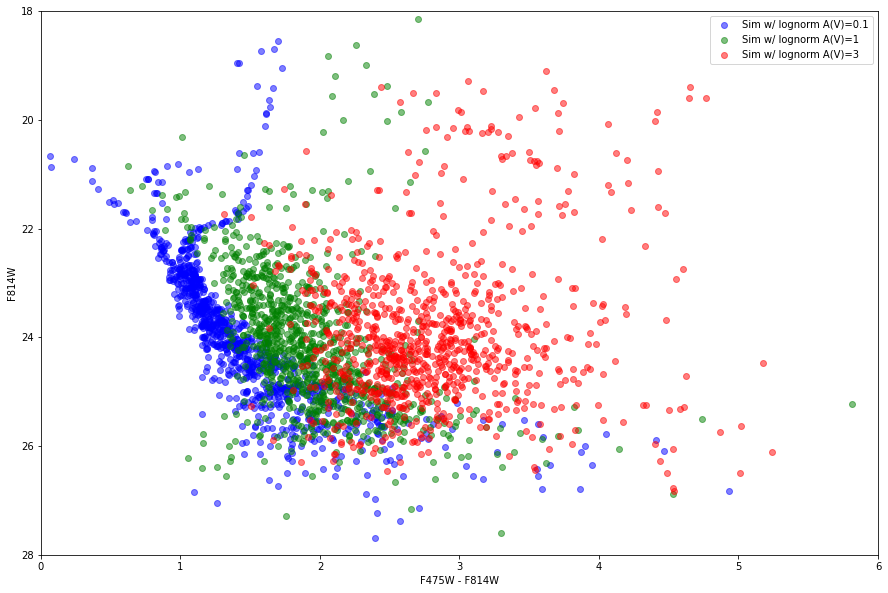

In [8]:
import matplotlib.pyplot as plt

band1 = "F475W"
band2 = "F814W"
plt.figure(figsize=(15, 10))
plt.plot(simcat_av01[f"{band1}_VEGA"] - simcat_av01[f"{band2}_VEGA"], simcat_av01[f"{band2}_VEGA"],
         "bo", label="Sim w/ lognorm A(V)=0.1", alpha=0.5)
plt.plot(simcat_av1[f"{band1}_VEGA"] - simcat_av1[f"{band2}_VEGA"], simcat_av1[f"{band2}_VEGA"],
         "go", label="Sim w/ lognorm A(V)=1", alpha=0.5)
plt.plot(simcat_av3[f"{band1}_VEGA"] - simcat_av3[f"{band2}_VEGA"], simcat_av3[f"{band2}_VEGA"],
         "ro", label="Sim w/ lognorm A(V)=3", alpha=0.5)
plt.xlim(0.0, 6.0)
plt.ylim(28, 18)
plt.xlabel(f"{band1} - {band2}")
plt.ylabel(f"{band2}")
plt.legend()

## Simulate a range of A(V) widths


In [9]:
mod.physics_model["Av"]["mean"] = 1.0
mod.physics_model["Av"]["sigma"] = 0.1
simcat_avs01 = simulate_obs(
    "../beast_sim/scylla_sim/scylla_sim_seds.grid.hd5",
    "../beast_sim/scylla_sim/scylla_sim_noisemodel.grid.hd5",
    mbmodel=mod,
    nsim=1000,
    compl_filter="F475W",
    weight_to_use="weight",
)
simcat_avs01.write("../beast_sim/scylla_sim_av_var/scylla_sim_avsig01.fits",overwrite=True)

computing megabeast ensemble physics model (replaces beast priors)
computing the distance plus weights for dist =  60000.0
computing the age-mass-metallicity grid weight for Z =  0.00762
Completeness from HST_WFC3_F475W
number of simulated stars = 1000


In [10]:
mod.physics_model["Av"]["mean"] = 1.0
mod.physics_model["Av"]["sigma"] = 0.5
simcat_avs05 = simulate_obs(
    "../beast_sim/scylla_sim/scylla_sim_seds.grid.hd5",
    "../beast_sim/scylla_sim/scylla_sim_noisemodel.grid.hd5",
    mbmodel=mod,
    nsim=1000,
    compl_filter="F475W",
    weight_to_use="weight",
)
simcat_avs05.write("../beast_sim/scylla_sim_av_var/scylla_sim_avsig05.fits",overwrite=True)

computing megabeast ensemble physics model (replaces beast priors)
computing the distance plus weights for dist =  60000.0
computing the age-mass-metallicity grid weight for Z =  0.00762
Completeness from HST_WFC3_F475W
number of simulated stars = 1000


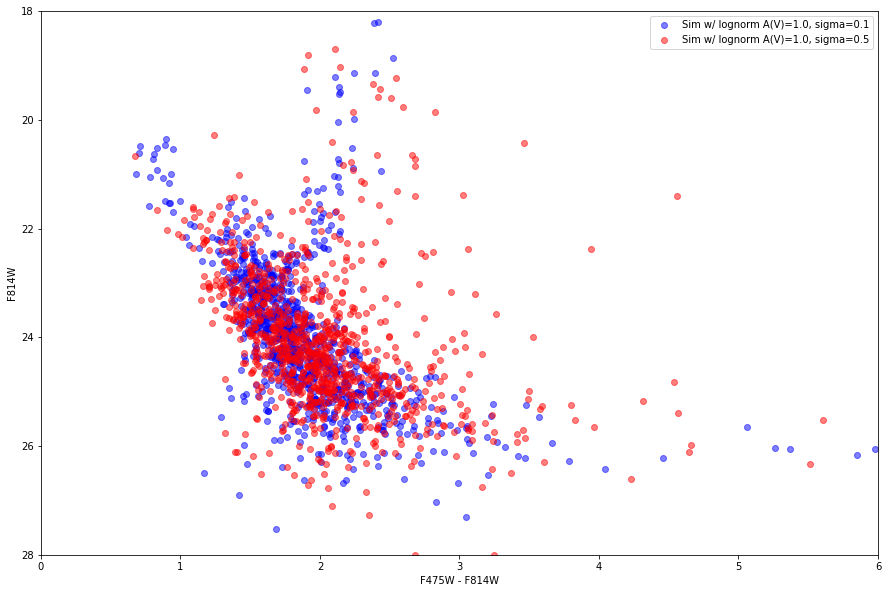

In [11]:
band1 = "F475W"
band2 = "F814W"
plt.figure(figsize=(15, 10))
plt.plot(simcat_avs01[f"{band1}_VEGA"] - simcat_avs01[f"{band2}_VEGA"], simcat_avs01[f"{band2}_VEGA"],
         "bo", label="Sim w/ lognorm A(V)=1.0, sigma=0.1", alpha=0.5)
plt.plot(simcat_avs05[f"{band1}_VEGA"] - simcat_avs05[f"{band2}_VEGA"], simcat_avs05[f"{band2}_VEGA"],
         "ro", label="Sim w/ lognorm A(V)=1.0, sigma=0.5", alpha=0.5)
plt.xlim(0.0, 6.0)
plt.ylim(28, 18)
plt.xlabel(f"{band1} - {band2}")
plt.ylabel(f"{band2}")
plt.legend()